<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Ariana Koocheki Dariuni</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 400103624</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [ ]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [ ]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [ ]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.978618342232764, 0.7991585642167236, 0.46147936225293185, 0.7805291762864555, 0.11827442586893322, 0.6399210213275238, 0.1433532874090464, 0.9446689170495839, 0.5218483217500717, 0.4146619399905236]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** PUT YOUR ANSWER HERE :)


In [ ]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** PUT YOUR ANSWER HERE :)

In [ ]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [ ]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward = np.max(p_arr)  # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.978618342232764


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** PUT YOUR ANSWER HERE :)

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** PUT YOUR ANSWER HERE :)

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [ ]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(self.n_act)  # Placeholder
        return sel_act

In [ ]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


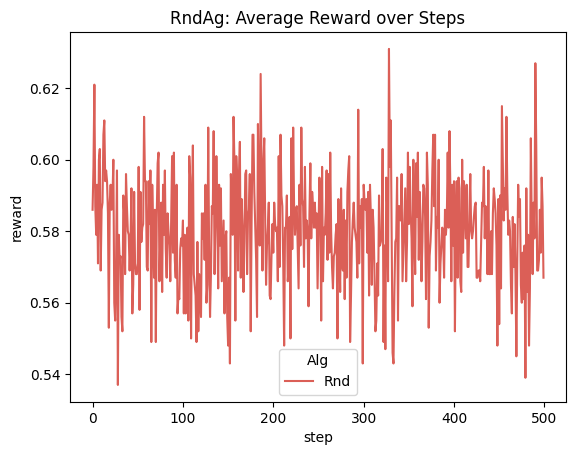

In [ ]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** PUT YOUR ANSWER HERE :)

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** PUT YOUR ANSWER HERE :)

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


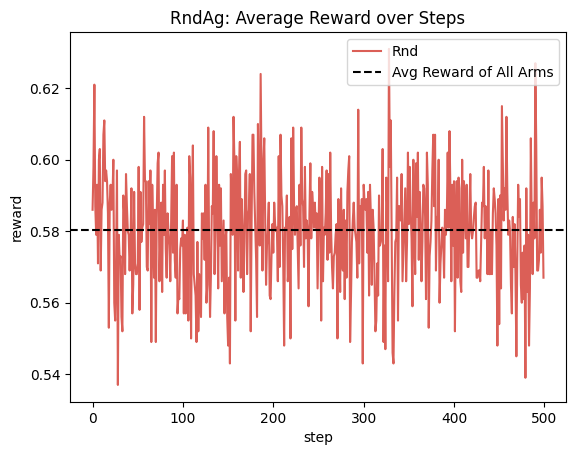

In [ ]:
# Plot RndAg reward curve and average reward of all arms (Simple)
ax = plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Calculate the average reward of all arms (i.e., the mean probability)
avg_reward = np.mean(p_arr)

# Overlay a horizontal line showing the average reward of all arms
ax.axhline(avg_reward, color='black', linestyle='--', label='Avg Reward of All Arms')


plt.title("RndAg: Average Reward over Steps")
plt.legend()
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [ ]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: update Q value (Simple placeholder)
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]

    def get_action(self):
        self.t += 1
        if self.t <= self.max_ex:
            return np.random.randint(self.n_act)
        return int(np.argmax(self.Q))


### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


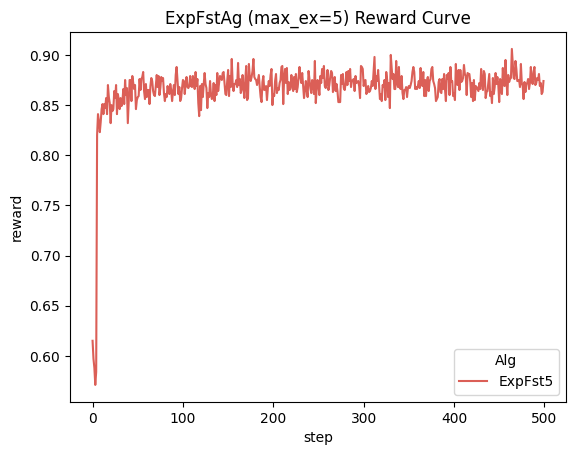

In [ ]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** PUT YOUR ANSWER HERE :)

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** PUT YOUR ANSWER HERE :)

Running ExpFstAg with max_ex=5...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=10...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=50...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=100...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=200...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


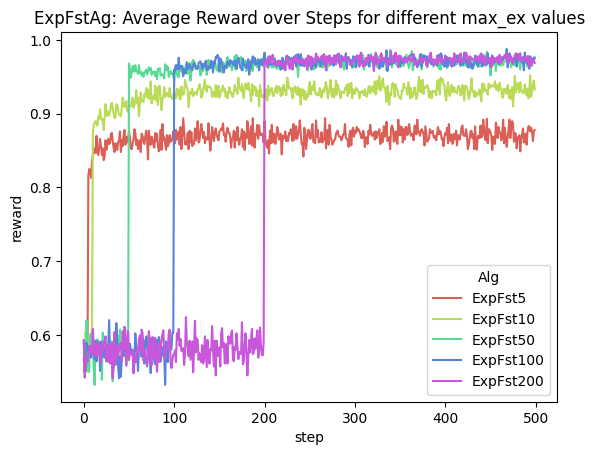

In [ ]:
# TODO: Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] (Simple placeholder)
expfst_res = []
max_ex_values = [5, 10, 50, 100, 200]

for ex in max_ex_values:
    print(f"Running ExpFstAg with max_ex={ex}...")
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log_df = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    expfst_res.append(log_df)

# Combine logs from all max_ex values
combined_logs = pd.concat(expfst_res, ignore_index=True)

# Plot the reward curves for each max_ex value
ax = plot_logs(combined_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg: Average Reward over Steps for different max_ex values")
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** PUT YOUR ANSWER HERE :)

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** PUT YOUR ANSWER HERE :)

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [ ]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: Update Q value (Simple placeholder)
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]


    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # TODO: Compute exploration bonus (Simple placeholder)
        bonus = np.sqrt((2 * np.log(self.t)) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = int(np.random.choice(np.flatnonzero(Q_explore == Q_explore.max())))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


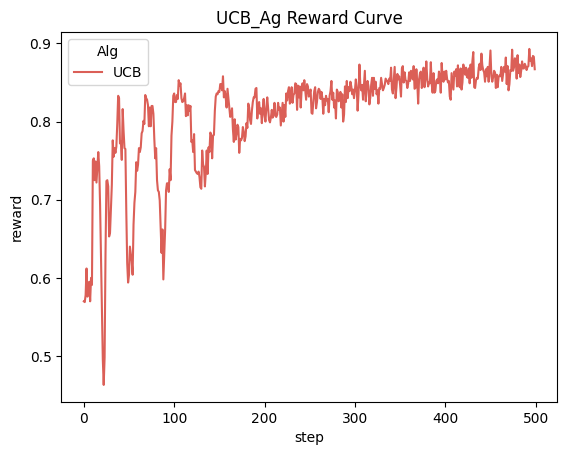

In [ ]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.


Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


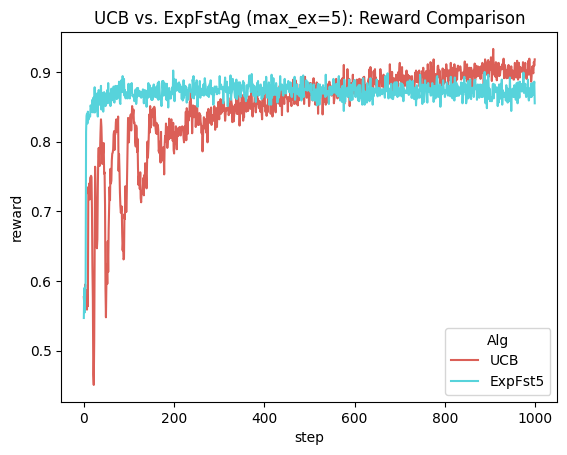

In [ ]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
print("Running comparison (Simple)...")

# Initialize the agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)

comparison = mab_swp( agents=[ucb_agent, expfst_agent],
                      p_arr=p_arr,
                      labels=['UCB', 'ExpFst5'],
                      n_runs=1000,
                      max_steps=1000 )

ax = plot_logs(comparison, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=5): Reward Comparison")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


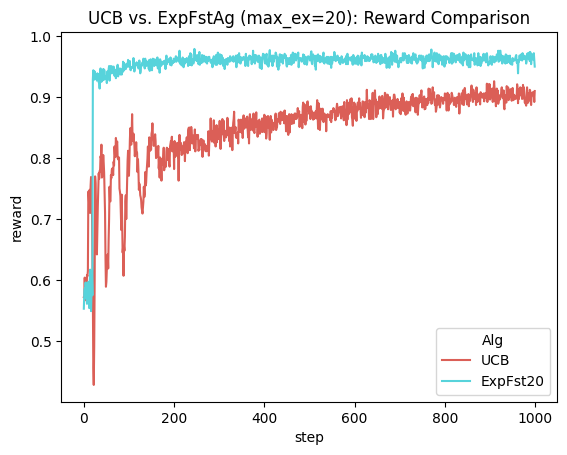

In [ ]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=20) for 1000 runs, 1000 steps (Simple placeholder)
print("Running comparison (Simple)...")

# Initialize the ExpFstAg agent
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)

comparison = mab_swp( agents=[ucb_agent, expfst_agent],
                      p_arr=p_arr,
                      labels=['UCB', 'ExpFst20'],
                      n_runs=1000,
                      max_steps=1000 )

ax = plot_logs(comparison, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=20): Reward Comparison")
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** PUT YOUR ANSWER HERE :)

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** PUT YOUR ANSWER HERE :)

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** PUT YOUR ANSWER HERE :) (Discuss how hyperparameter tuning and early exploitation can sometimes yield higher rewards in finite-time scenarios.)

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


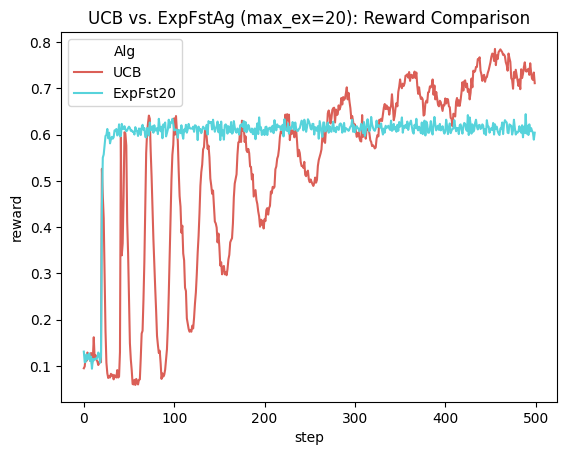

In [ ]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

len_skewed_p = len(skewed_p)
# TODO: Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario (Simple placeholder)
print("Running comparison (Simple)...")

# Initialize the ExpFstAg agent
ucb_agent = UCB_Ag(n_act=len_skewed_p)

expfst_agent = ExpFstAg(n_act=len_skewed_p, max_ex=len_skewed_p)

comparison = mab_swp( agents=[ucb_agent, expfst_agent],
                      p_arr=skewed_p,
                      labels=['UCB', f'ExpFst{len_skewed_p}'],
                      n_runs=1000,
                      max_steps=500 )

ax = plot_logs(comparison, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"UCB vs. ExpFstAg (max_ex={len_skewed_p}): Reward Comparison")
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [ ]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # TODO: Choose random action with probability eps [Simple]

        if np.random.random() < self.eps:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = int(np.random.choice(np.flatnonzero(self.Q == self.Q.max())))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** PUT YOUR ANSWER HERE :)

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** PUT YOUR ANSWER HERE :)


Running EpsGdAg experiments with various eps values... (Simple)
Running EpsGdAg with eps=0... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.1... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.2... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.4... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-2-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


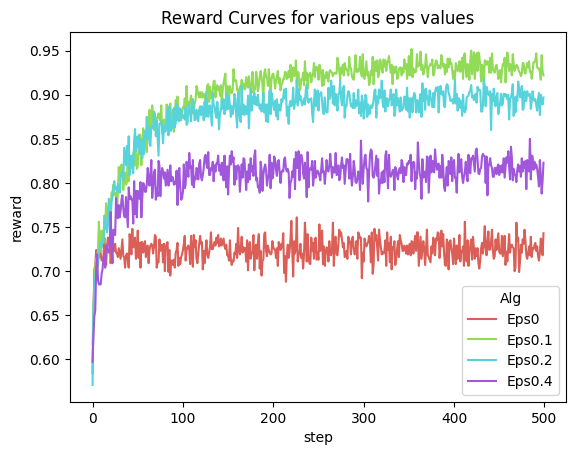

In [ ]:
# TODO: Plot reward curves for EpsGdAg with epsilons [0, 0.1, 0.2, 0.4] (Simple placeholder)
print("Running EpsGdAg experiments with various eps values... (Simple)")

epsilons = [0, 0.1, 0.2, 0.4]
eps_res = []

for eps in epsilons:
    print(f"Running EpsGdAg with eps={eps}... (Simple)")
    eps_agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    df = mab_swp([eps_agent], p_arr, [f'Eps{eps}'], n_runs=1000, max_steps=500)
    eps_res.append(df)

combined_res = pd.concat(eps_res, ignore_index=True)

ax = plot_logs(combined_res, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Reward Curves for various eps values")
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** PUT YOUR ANSWER HERE :)


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [ ]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [ ]:
# TODO: Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
ctxData = np.loadtxt("dataset.txt")  # Placeholder
print("Dataset loaded (Simple version):", ctxData.shape)

Dataset loaded (Simple version): (10000, 102)


In [ ]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [ ]:
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        # TODO: Compute UCB for arm a given state (Simple placeholder)

        x = np.array(state).reshape(-1, 1)
        A_inv = np.linalg.inv(self.As[a])
        theta = A_inv @ self.bs[a]
        p = (theta.T @ x)[0, 0] + self.alpha * np.sqrt((x.T @ A_inv @ x)[0, 0])
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        # TODO: Update A and b for arm a (Simple placeholder)
        x = np.array(state).reshape(-1, 1)
        self.As[a] += x @ x.T
        self.bs[a] += rew * x


    def get_action(self, state):
        # TODO: Compute UCB estimates for all arms (Simple placeholder)
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        # TODO: Choose arm with highest UCB (Simple placeholder)
        sel_act = np.random.choice(np.flatnonzero(np.array(p_est) == np.array(p_est).max()))
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** PUT YOUR ANSWER HERE :)

In [ ]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [ ]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [ ]:
# TODO: Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1 (Simple placeholder)
print("Running LinUCB sweep (Simple version)...")
logs_ctx = ctxBnd_swp(alphas=[0, 0.01, 0.1, 0.5], data=ctxData, n_runs=1)  # Placeholder

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-28-e32287803f11>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


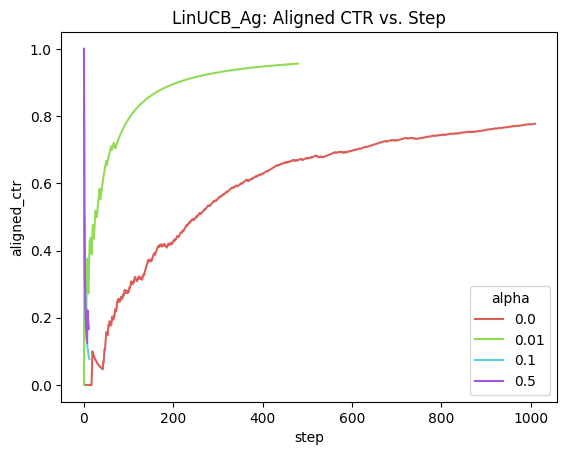

In [ ]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** PUT YOUR ANSWER HERE :)

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** PUT YOUR ANSWER HERE :)

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.


## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.


## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.


## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.


## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.


##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.